# Exploratory data analysis: Wine quality data

In [74]:
# Required modules
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from typing import Tuple


In [8]:
# Import raw data
raw_data = pd.read_csv("../data/winequalityN.csv")
raw_data.head()

raw_data = pd.get_dummies(raw_data)
raw_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1


In [29]:
X = raw_data.drop(['quality'], axis=1)
y = raw_data.quality

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=128)

features = X.columns
target_variable = y.name



## Data cleaning

### Missing values

In [10]:
def check_null_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(
        ascending=False
    )
    missing_data = pd.concat([total, percent * 100], axis=1, keys=["Total", "Percent"])
    return missing_data

In [11]:
check_null_values(X_train)

,Total,Percent
volatile acidity,7,0.134693
pH,7,0.134693
fixed acidity,6,0.115451
sulphates,4,0.076967
citric acid,2,0.038484
chlorides,2,0.038484
residual sugar,1,0.019242
free sulfur dioxide,0,0.000000
total sulfur dioxide,0,0.000000
density,0,0.000000


In [12]:
check_null_values(X_test)

,Total,Percent
fixed acidity,4,0.307692
pH,2,0.153846
volatile acidity,1,0.076923
citric acid,1,0.076923
residual sugar,1,0.076923
chlorides,0,0.000000
free sulfur dioxide,0,0.000000
total sulfur dioxide,0,0.000000
density,0,0.000000
sulphates,0,0.000000


### Impute missing values

In [13]:
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train))
X_test = pd.DataFrame(imputer.transform(X_test)) 

X_train.columns = features
X_test.columns = features

In [14]:
check_null_values(X_train)

,Total,Percent
fixed acidity,0,0.0
volatile acidity,0,0.0
citric acid,0,0.0
residual sugar,0,0.0
chlorides,0,0.0
free sulfur dioxide,0,0.0
total sulfur dioxide,0,0.0
density,0,0.0
pH,0,0.0
sulphates,0,0.0


In [15]:
check_null_values(X_test)

,Total,Percent
fixed acidity,0,0.0
volatile acidity,0,0.0
citric acid,0,0.0
residual sugar,0,0.0
chlorides,0,0.0
free sulfur dioxide,0,0.0
total sulfur dioxide,0,0.0
density,0,0.0
pH,0,0.0
sulphates,0,0.0


## Data exploration

### Correlation between variables

In [90]:
   def plot_corr_matrix(df : pd.DataFrame(), size : Tuple) -> None:
    corr_matrix = df.corr()
    sns.set(rc={'figure.figsize':size})
    dropSelf = np.zeros_like(corr_matrix)
    dropSelf[np.triu_indices_from(dropSelf)] = True
    sns.heatmap(corr_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
    sns.set(font_scale=1.5)
    

In [54]:
_ = pd.concat([X_train, y_train], axis=1)

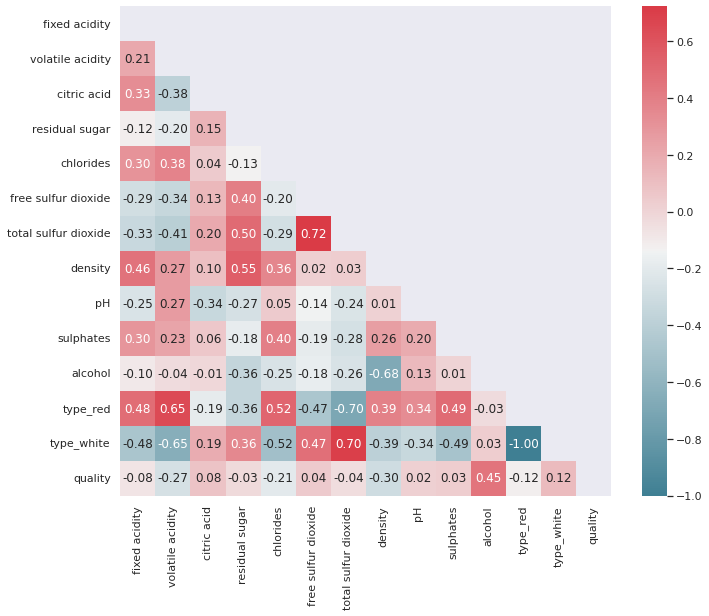

In [67]:
plot_corr_matrix(df=_, size=())